In [1]:
import os
import pandas as pd
import chromadb
import uuid

In [2]:
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment = "text-embedding-3-small",
    azure_endpoint = "https://eastus.api.cognitive.microsoft.com/",
    api_key = "27a3e6d835d44c298e146a73c7abdedd",

)

/home/zadmin/Desktop/GAAI-B4-Azure/genai/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def generate_embeddings(x):
    # generate the embedding for the given text and return embeddings
    return embeddings.embed_query(x)

In [4]:
# read the data from source
input_df = pd.read_csv(r"/home/zadmin/Desktop/aksh_assignment/assignment2/assignment2dataset.csv")

input_df['title_desc'] = input_df.apply(lambda x: str({'title': x['title'], 'description': x['description']}), axis=1)


# apply the embedding generation function on the title_desc column
input_df['title_desc_emb'] = input_df.apply(lambda x: generate_embeddings(x['title_desc']), axis=1)


#load the vector db

chroma_client = chromadb.Client()
collection_name = 'course_description'
collection = chroma_client.get_or_create_collection(name=collection_name)

ids = [str(uuid.uuid4()) for _ in range(len(input_df))]

# add documents
collection.add( 
    ids = ids,
    documents = input_df['title_desc'].to_list(),
    metadatas=  input_df.drop(columns=["title_desc", "title_desc_emb"], axis=1).to_dict(orient="records"), 
    embeddings = input_df['title_desc_emb'].to_list()   
)

print("Number of docs dumped into vector DB")
print(len(collection.get()['ids']))

Number of docs dumped into vector DB
25


In [5]:
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough


message = """
You are an intelligent course recommendation assistant, You are provided with the question, 
Course which are completed and their interst blurb. Provide the crisp and precise output based on the context.
You are not supposed to answer anything from outside the context.
If the context does not have the content to answer the question


Input: 
{question}

Context:
{context}
"""

prompt = PromptTemplate.from_template(message)


In [12]:
from langchain_openai import AzureChatOpenAI
model_name = "gpt4o"
llm = AzureChatOpenAI(model= model_name,
                    api_key = "27a3e6d835d44c298e146a73c7abdedd",
                    azure_endpoint = "https://eastus.api.cognitive.microsoft.com/",
                    api_version = "2024-08-01-preview"
)

In [13]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class mystate(TypedDict):
    question:str
    collection_name: str
    question_emb: List
    context: List[Document]
    prompt: str
    answer: str

In [19]:
def chunk_retriever(state: mystate) -> mystate:
    question = state['question']
    print(question)
    question_emb = generate_embeddings(question)
    response = collection.query(query_embeddings = question_emb,
                 n_results=2, 
                  )
    generated_context = ', '.join(response['documents'][0])
    return {"context":generated_context, "question_emb":question_emb} 
    


# generation node
def generate(state:mystate)->mystate:
    doc_content = state['context']
    messages = prompt.invoke({"question":state['question'],"context":doc_content})
    response = llm.invoke(messages)
    return {"prompt": prompt, "answer":response.content}
    

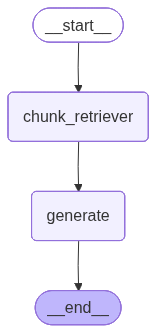

In [21]:
from langgraph.graph import START, StateGraph

builder = StateGraph(mystate)
builder.add_sequence([chunk_retriever,generate])
builder.add_edge(START,"chunk_retriever")
graph = builder.compile()
graph

In [30]:
question = """ I’ve completed the ‘Python Programming for Data Science’ course and enjoy data visualization. What should I take next?"""

response = graph.invoke({"question": question})
print("Question: ", response['question'], "\nAnswer: ", response['answer'])

 I’ve completed the ‘Python Programming for Data Science’ course and enjoy data visualization. What should I take next?
Question:   I’ve completed the ‘Python Programming for Data Science’ course and enjoy data visualization. What should I take next? 
Answer:  Based on your interest in data visualization and your completion of the 'Python Programming for Data Science' course, you should consider taking the 'Data Visualization with Tableau' course. This course will enhance your skills in transforming data into visual stories and creating interactive dashboards, which aligns well with your interests.


In [31]:
question = """ “I know Azure basics and want to manage containers and build CI/CD pipelines. 
Recommend courses. """

response = graph.invoke({"question": question})
print("Question: ", response['question'], "\nAnswer: ", response['answer'])

 “I know Azure basics and want to manage containers and build CI/CD pipelines. 
Recommend courses. 
Question:   “I know Azure basics and want to manage containers and build CI/CD pipelines. 
Recommend courses.  
Answer:  Based on your knowledge of Azure basics and your interest in managing containers and building CI/CD pipelines, I recommend the following course:

**Containerization with Docker and Kubernetes**: This course will teach you container fundamentals with Docker and advance to Kubernetes for orchestration, which is essential for managing containers. It covers deployment of microservices architectures and includes hands-on labs to ensure reliability and streamlined DevOps workflows.


In [32]:
question = """ My background is in ML fundamentals; I’d like to specialize in neural networks and 
production workflows. """

response = graph.invoke({"question": question})
print("Question: ", response['question'], "\nAnswer: ", response['answer'])

 My background is in ML fundamentals; I’d like to specialize in neural networks and 
production workflows. 
Question:   My background is in ML fundamentals; I’d like to specialize in neural networks and 
production workflows.  
Answer:  Based on your background in ML fundamentals and interest in specializing in neural networks and production workflows, I recommend the following courses:

1. **MLOps: Productionizing Machine Learning** - This course focuses on deploying and maintaining ML models at scale, which aligns with your interest in production workflows. You'll learn about model versioning, containerization, CI/CD, and building end-to-end pipelines.

2. **Foundations of Machine Learning** - This course will strengthen your understanding of foundational ML algorithms and concepts that are essential before diving deeper into specialized areas like neural networks.


In [33]:
question = """ I want to learn to build and deploy microservices with Kubernetes—what courses fit 
best? """

response = graph.invoke({"question": question})
print("Question: ", response['question'], "\nAnswer: ", response['answer'])

 I want to learn to build and deploy microservices with Kubernetes—what courses fit 
best? 
Question:   I want to learn to build and deploy microservices with Kubernetes—what courses fit 
best?  
Answer:  Based on your interest in building and deploying microservices with Kubernetes, the following courses fit best:

1. **Containerization with Docker and Kubernetes**: This course covers container fundamentals with Docker and advances to Kubernetes for orchestration, including deploying microservices architectures on a Kubernetes cluster.

2. **APIs and Microservices Architecture**: This course focuses on designing and implementing microservices with RESTful and GraphQL APIs, along with containerized deployment and microservices patterns, which are integral for managing services in a Kubernetes environment.


In [34]:


question = """ I’m interested in blockchain and smart contracts but have no prior experience. Which 
courses do you suggest? """

response = graph.invoke({"question": question})
print("Question: ", response['question'], "\nAnswer: ", response['answer'])

 I’m interested in blockchain and smart contracts but have no prior experience. Which 
courses do you suggest? 
Question:   I’m interested in blockchain and smart contracts but have no prior experience. Which 
courses do you suggest?  
Answer:  I recommend the course titled **"Blockchain Technology and Smart Contracts."** This course will help you understand blockchain fundamentals and learn to develop smart contracts using Solidity on Ethereum, making it suitable for someone with no prior experience in the field.
